### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

### Checking the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape, test.shape)

(512087, 11) (36000, 9)


In [3]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [4]:
train.nunique()

ID                    512087
Day_No                   882
Course_ID                600
Course_Domain              4
Course_Type                3
Short_Promotion            2
Public_Holiday             2
Long_Promotion             2
User_Traffic            3475
Competition_Metric       196
Sales                    544
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512087 entries, 0 to 512086
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  512087 non-null  int64  
 1   Day_No              512087 non-null  int64  
 2   Course_ID           512087 non-null  int64  
 3   Course_Domain       512087 non-null  object 
 4   Course_Type         512087 non-null  object 
 5   Short_Promotion     512087 non-null  int64  
 6   Public_Holiday      512087 non-null  int64  
 7   Long_Promotion      512087 non-null  int64  
 8   User_Traffic        512087 non-null  int64  
 9   Competition_Metric  510323 non-null  float64
 10  Sales               512087 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 43.0+ MB


In [6]:
train.describe()

,ID,Day_No,Course_ID,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
count,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,512087.000000,510323.000000,512087.000000
mean,274007.300650,434.917869,300.388344,0.380244,0.031639,0.488968,15375.101198,0.073345,120.826924
std,158228.834029,256.044161,173.365787,0.485447,0.175038,0.499879,7727.231205,0.100115,54.355258
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000
25%,136962.500000,214.000000,150.000000,0.000000,0.000000,0.000000,10584.000000,0.010000,84.000000
50%,273984.000000,427.000000,300.000000,0.000000,0.000000,0.000000,13776.000000,0.035000,111.000000
75%,411065.500000,658.000000,451.000000,1.000000,0.000000,1.000000,18123.000000,0.094000,146.000000
max,548027.000000,882.000000,600.000000,1.000000,1.000000,1.000000,100002.000000,0.768000,682.000000


### Missing values

In [7]:
#Function to check null values
def null_check(df, heatmap=False):
    if heatmap:
        plt.figure(figsize=(15,12))
        sns.heatmap(df.isnull())
        plt.show()
    
    nulls = pd.DataFrame({'count':df.isnull().sum(),'percent':round(df.isnull().sum()*100/df.shape[0],2)})
    return nulls[nulls['count']>0].sort_values('count',ascending=False)

In [8]:
#Missing values in 'train'
null_check(train)

,count,percent
Competition_Metric,1764,0.34


In [9]:
#Missing values in 'test'
null_check(test)

,count,percent
Competition_Metric,120,0.33


Missing value % is low, we will try to impute.

In [10]:
train['Competition_Metric'].describe()

count    510323.000000
mean          0.073345
std           0.100115
min           0.000000
25%           0.010000
50%           0.035000
75%           0.094000
max           0.768000
Name: Competition_Metric, dtype: float64

<AxesSubplot:>

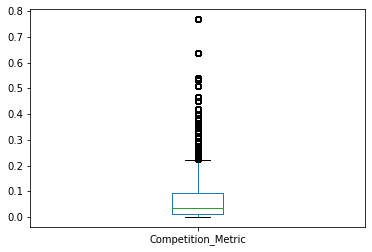

In [11]:
train['Competition_Metric'].plot(kind='box')

Imputing with median due to presence of outliers.

In [12]:
train['Competition_Metric'].fillna(train['Competition_Metric'].median(), inplace=True)
test['Competition_Metric'].fillna(train['Competition_Metric'].median(), inplace=True)

### Checking categories

In [13]:
#Checking the categories in categorical columns
for i in train.columns:
    if train[i].nunique() < 25:
        print(i+' (%)')
        print('`'*50)
        print(round(train[i].value_counts(normalize=True, dropna=False),4)*100)
        print()

Course_Domain (%)
``````````````````````````````````````````````````
Development             51.61
Software Marketing      32.45
Finance & Accounting    15.08
Business                 0.86
Name: Course_Domain, dtype: float64

Course_Type (%)
``````````````````````````````````````````````````
Course     51.31
Program    48.35
Degree      0.34
Name: Course_Type, dtype: float64

Short_Promotion (%)
``````````````````````````````````````````````````
0    61.98
1    38.02
Name: Short_Promotion, dtype: float64

Public_Holiday (%)
``````````````````````````````````````````````````
0    96.84
1     3.16
Name: Public_Holiday, dtype: float64

Long_Promotion (%)
``````````````````````````````````````````````````
0    51.1
1    48.9
Name: Long_Promotion, dtype: float64



No ill-categories or skewed categories(Except `Public_Holiday`).

##### Dropping 'ID'  since it's just a identifier, also dropping 'User_Traffic' since this data is not available in test set.

In [14]:
#Dropping in train
train.drop(['ID','User_Traffic'], axis=1, inplace=True)

In [15]:
#Dropping in test | storing in original 'test' for final submission
test_f = test.drop('ID', axis=1)

### Univariate Analysis

In [16]:
#Function for categorical columns
def uni_cat(col, df, rot=0):
    #Value counts of categories 
    print(f'Counts of {col}')
    print('-'*25)
    print(pd.DataFrame({'#':df[col].value_counts(dropna=False), '%':round(df[col].value_counts(normalize=True, dropna=False)*100,2)}))
    
    #Countplots
    plt.figure(figsize=(15,4))
    sns.countplot(df[col])
    plt.title(f'Counts in {col}')
    plt.xticks(rotation=rot)
    plt.show()

#Function for numerical columns
def uni_num(col, df, new_percentiles=[]):
    #Null values
    if df[col].isnull().sum()>0:
        print(f'Null values in {col}: {df[col].isnull().sum()}')
    
    #Description of column
    print(f'Desription of {col}')
    print('-'*25)
    percentiles=[0.1,0.25,0.5,0.75,0.9]
    percentiles.extend(new_percentiles)
    print(df[col].describe(percentiles=percentiles))
    
    #Subplots
    fig,axes=plt.subplots(1,2, figsize=(15,4))
    
    #Distribution plot
    sns.distplot(df[col], ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    
    #Boxplot
    sns.boxplot(df[col], ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    
    plt.show()

#### `Day_No`

Desription of Day_No
-------------------------
count    512087.000000
mean        434.917869
std         256.044161
min           1.000000
10%          86.000000
25%         214.000000
50%         427.000000
75%         658.000000
90%         797.000000
max         882.000000
Name: Day_No, dtype: float64


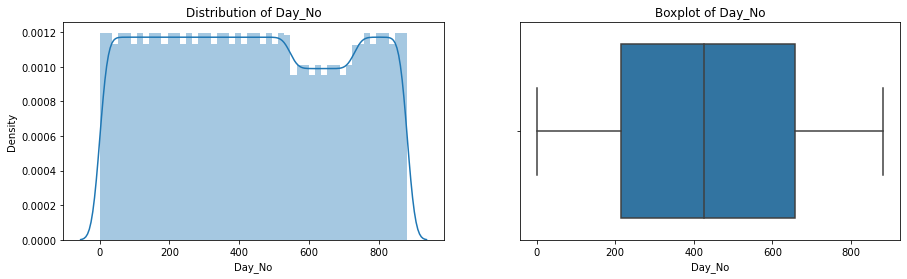

In [17]:
uni_num('Day_No', train)

The amount of data seems to be consistent across all the 'number of days' except between ~500-700. We will drop this after creating a new feature `Day_Of_Week`

Counts of Day_Of_Week
-------------------------
       #      %
6  73182  14.29
5  73182  14.29
4  73182  14.29
3  73182  14.29
0  73182  14.29
2  73089  14.27
1  73088  14.27


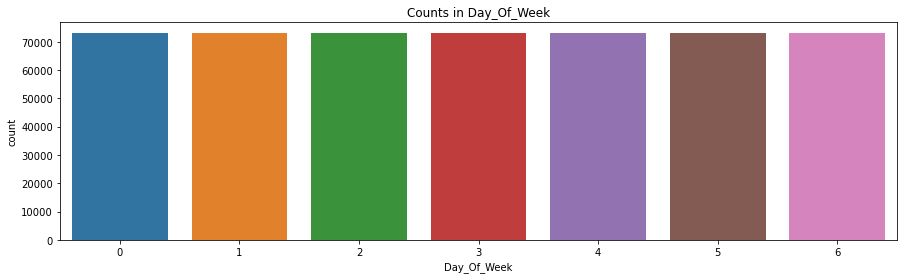

In [50]:
train['Day_Of_Week'] = train['Day_No'].apply(lambda x: x%7)
test['Day_Of_Week'] = test['Day_No'].apply(lambda x: x%7)

uni_cat('Day_Of_Week', train)

In [51]:
train.drop('Day_No', axis=1, inplace=True)
test_f.drop('Day_No', axis=1, inplace=True)

#### `Course_ID`

Desription of Course_ID
-------------------------
count    512087.000000
mean        300.388344
std         173.365787
min           1.000000
10%          60.000000
25%         150.000000
50%         300.000000
75%         451.000000
90%         541.000000
max         600.000000
Name: Course_ID, dtype: float64


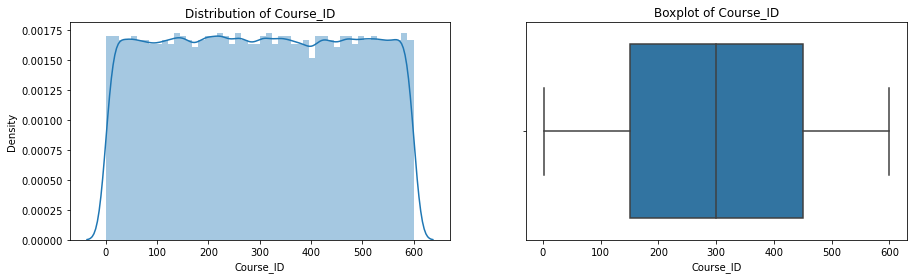

In [17]:
uni_num('Course_ID', train)

In [18]:
#Unique counts of course IDs
train['Course_ID'].value_counts().unique()

array([882, 881, 698], dtype=int64)

Based on the above counts, we will rank the course_ID based on the enrollment counts in ascending order.

In [19]:
#Creating a ranked dataframed
Course_ID_ranks = pd.DataFrame(train['Course_ID'].value_counts().map({882:3,881:2,698:1})).reset_index()
Course_ID_ranks.columns = ['Course_ID','Rank']
Course_ID_ranks

,Course_ID,Rank
0,361,3
1,326,3
2,584,3
3,328,3
4,72,3
...,...,...
595,407,1
596,592,1
597,78,1
598,551,1


In [20]:
#Adding rank column
train = train.merge(Course_ID_ranks, how='left')
test_f = test_f.merge(Course_ID_ranks, how='left')

Counts of Rank
-------------------------
        #      %
3  446292  87.15
1   64914  12.68
2     881   0.17


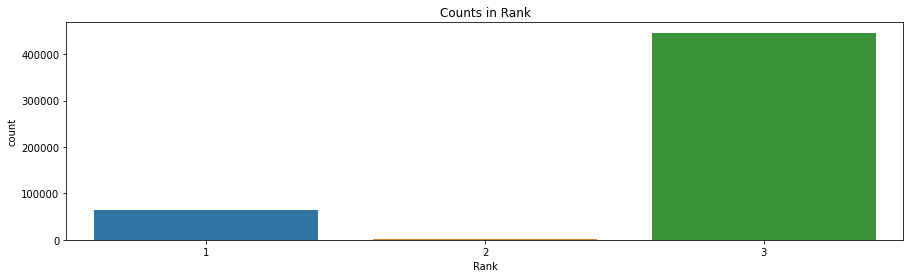

In [21]:
uni_cat('Rank', train)

The categories seem to be heavily imbalanced.

In [22]:
test_f['Rank'].value_counts(dropna=False)

3    30360
1     5580
2       60
Name: Rank, dtype: int64

In [48]:
#Dropping 'Course_ID'
train.drop('Course_ID', axis=1, inplace=True)
test_f.drop('Course_ID', axis=1, inplace=True)

#### `Course_Domain`

Counts of Course_Domain
-------------------------
                           #      %
Development           264295  51.61
Software Marketing    166172  32.45
Finance & Accounting   77210  15.08
Business                4410   0.86


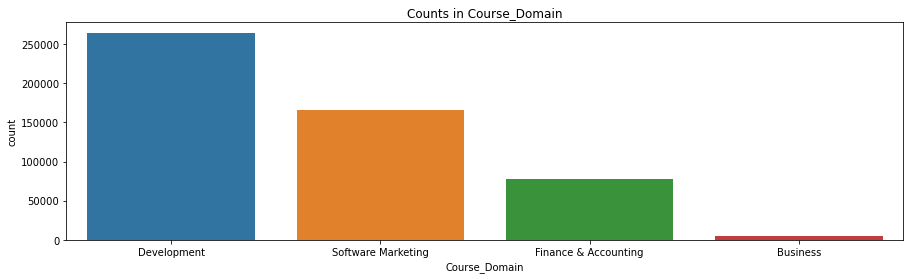

In [24]:
uni_cat('Course_Domain', train)

`Business` will be dropped manually as a category after dummying this column.

#### `Course_Type`

Counts of Course_Type
-------------------------
              #      %
Course   262747  51.31
Program  247576  48.35
Degree     1764   0.34


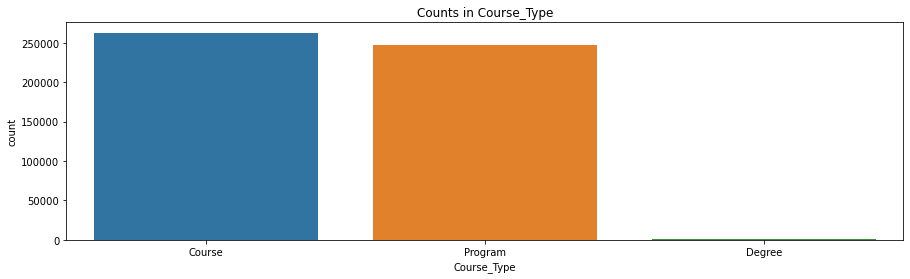

In [25]:
uni_cat('Course_Type', train)

`Degree` will be dropped manually as a category after dummying this column.

#### `Short_Promotion`

Counts of Short_Promotion
-------------------------
        #      %
0  317369  61.98
1  194718  38.02


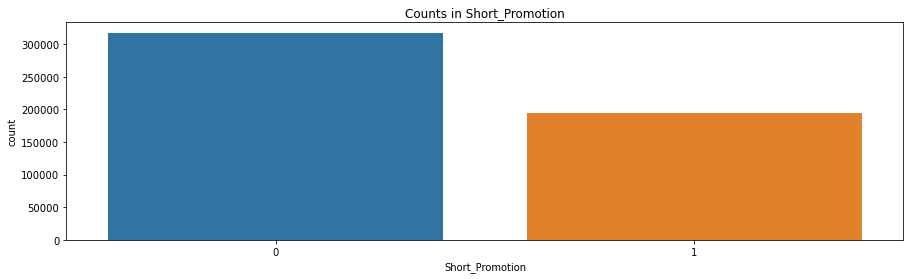

In [26]:
uni_cat('Short_Promotion', train)

Counts of Public_Holiday
-------------------------
        #      %
0  495885  96.84
1   16202   3.16


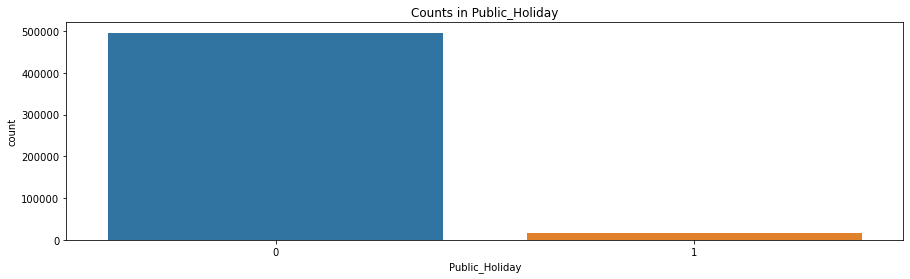

In [27]:
uni_cat('Public_Holiday', train)

The category is highly skewed. It would be better to drop it.

In [28]:
train.drop('Public_Holiday', axis=1, inplace=True)

#### `Long_Promotion`

Counts of Long_Promotion
-------------------------
        #     %
0  261693  51.1
1  250394  48.9


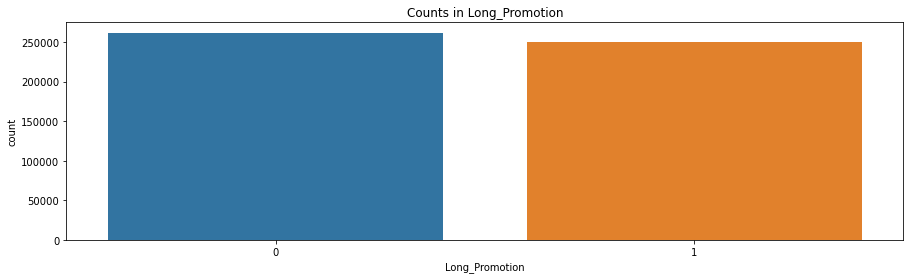

In [29]:
uni_cat('Long_Promotion', train)

#### `Competition_Metric`

Desription of Competition_Metric
-------------------------
count    512087.000000
mean          0.073213
std           0.099968
min           0.000000
10%           0.003000
25%           0.010000
50%           0.035000
75%           0.094000
90%           0.213000
max           0.768000
Name: Competition_Metric, dtype: float64


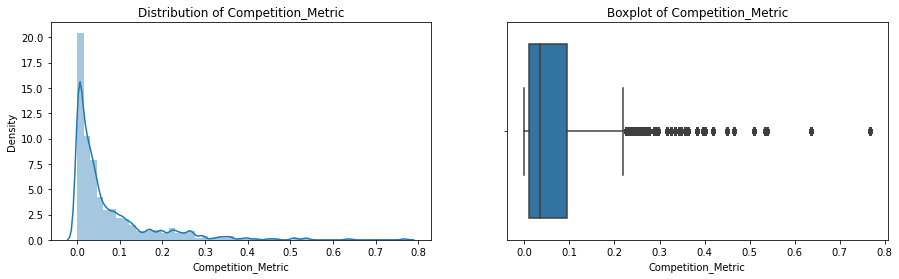

In [31]:
uni_num('Competition_Metric', train)

The number of outliers are quite high, most probably _`log transformation`_ will be helpful.

count    512087.000000
mean         -3.468118
std           1.462640
min          -6.907755
25%          -4.509860
50%          -3.324236
75%          -2.353878
max          -0.262664
Name: Competition_Metric, dtype: float64

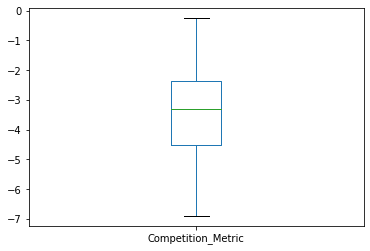

In [32]:
#Checking with log transformation
np.log(train['Competition_Metric']+0.001).plot(kind='box')
np.log(train['Competition_Metric']+0.001).describe()

Since the log transformation works well to treat the outliers, respective treatment will be applied.

In [33]:
#Transforming in both sets
train['Competition_Metric'] = np.log(train['Competition_Metric']+0.001)
test['Competition_Metric'] = np.log(test['Competition_Metric']+0.001)

### `Sales` - Target

Desription of Sales
-------------------------
count    512087.000000
mean        120.826924
std          54.355258
min           0.000000
10%          64.000000
25%          84.000000
50%         111.000000
75%         146.000000
90%         189.000000
max         682.000000
Name: Sales, dtype: float64


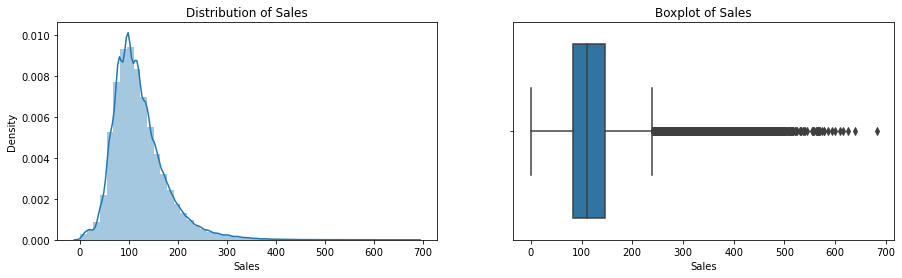

In [34]:
uni_num('Sales', train)

The number of outliers are too high. We will try to normalize this plot with the help of a _`square root transformation`_

In [45]:
train['Sales'] = np.sqrt(train['Sales'])

### Data Preparation

In [54]:
#Dummies
train_d = pd.get_dummies(train)
test_d = pd.get_dummies(test_f)

We will drop the categories - `Degree` and `Business` manually from the dummified dataset for both train and test due to low number of observations.

In [55]:
#Dropping the columns
train_d.drop(['Course_Domain_Business', 'Course_Type_Degree'], axis=1, inplace=True)
test_d.drop(['Course_Domain_Business', 'Course_Type_Degree'], axis=1, inplace=True)

<AxesSubplot:>

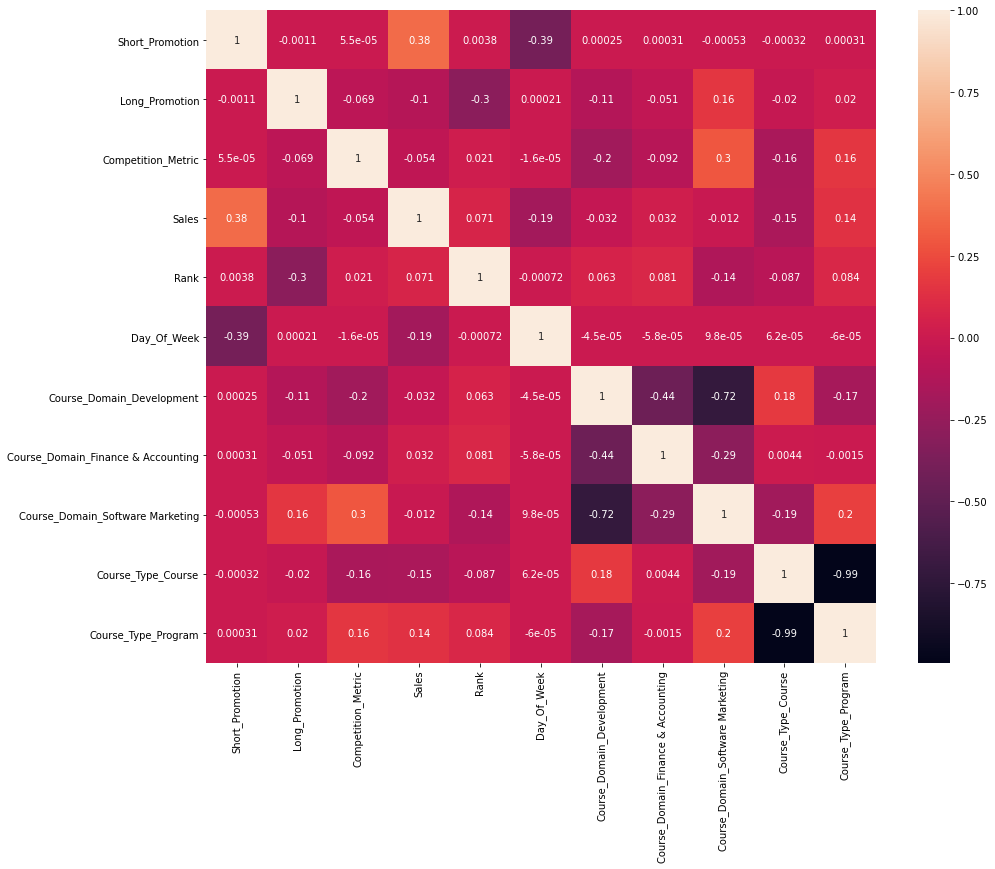

In [56]:
plt.figure(figsize=(15,12))
sns.heatmap(train_d.corr(), annot=True)

In [58]:
#Dividing the dataset
X = train_d.drop('Sales', axis=1)
y = train_d['Sales']

#Train-cv split
X_train, X_cv, y_train, y_cv = train_test_split(X,y,train_size=0.75, random_state=19)

for i in [X_train, X_cv, y_train, y_cv]:
    print(i.shape)

(384065, 10)
(128022, 10)
(384065,)
(128022,)


In [62]:
#Scaling
scale = MinMaxScaler()

X_train = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)
X_cv = scale.transform(X_cv)
X_test = scale.transform(test_d)

## Modelling

In [63]:
#function for the final metric
def rmsle(y_true,y_pred):
    return 1000*(mean_squared_log_error(y_true,y_pred)**0.5)

In [64]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

In [65]:
metrics=pd.DataFrame(columns=['Train','Test'])

In [66]:
### KNN

model = KNeighborsRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['KNN'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.5859767367462883 0.5817993372419632


In [67]:
### Lasso

model = Lasso()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['Lasso'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.0 -4.687530192892808e-07


In [68]:
### Ridge

model = Ridge()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['Ridge'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.19889244877019419 0.1997524292562446


In [69]:
### DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['DT'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.6549062471282308 0.6514220463034976


In [70]:
### RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['RandomForestRegressor'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.6548631572713458 0.6513855362829231


In [71]:
### XGB

model = XGBRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['XGB'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.6298806138165092 0.6309689713354494


In [72]:
### LGB

model = LGBMRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['LGB'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.5366732051803984 0.5397844852404947


In [73]:
### AdaBoost

model = AdaBoostRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['AdaBoost'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.2152092323428254 0.21728763992248423


In [74]:
### GradientBoostingRegressor

model = GradientBoostingRegressor()
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

metrics.loc['GBRegressor'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.3295606869342568 0.33148324537607476


In [75]:
metrics.sort_values('Train')

,Train,Test
DT,134.345731,134.124868
RandomForestRegressor,134.351708,134.131232
XGB,138.495018,137.438658
KNN,144.511265,144.368049
LGB,151.933245,150.615606
GBRegressor,177.387118,176.309100
Ridge,191.161665,190.225178
AdaBoost,191.173099,190.114960
Lasso,212.057002,211.238977


The best cases seem to be with:
1. DT
2. RF
3. XGB

We will try to tune the parameters for these.

## Hyperparameter Tuning

In [78]:
hp_metrics=pd.DataFrame(columns=['Train','Test'])

In [79]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

##### DT Hyperparameter tuning

In [80]:
estimator = DecisionTreeRegressor()
params = {'max_depth':[None,10,30,50,100],
          'min_samples_split':[None,10,30,50,100],
          'ccp_alpha':[0,0.001,0.01,0.1,1],
          'min_samples_leaf':[None,1,5,10,25,50,100]
         }

dt = GridSearchCV(estimator, params, n_jobs=-1, verbose=3, return_train_score=True, scoring='neg_mean_squared_log_error', cv=3)
dt.fit(X_train,y_train)

Fitting 3 folds for each of 1750 candidates, totalling 5250 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                         'criterion': ['mse', 'friedman_mse'],
                         'max_depth': [None, 10, 30, 50, 100],
                         'min_samples_leaf': [None, 1, 5, 10, 25, 50, 100],
                         'min_samples_split': [None, 10, 30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_log_error',
             verbose=3)

In [81]:
dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0, min_samples_split=30)

In [82]:
#Train
y_pred_t = dt.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = dt.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

hp_metrics.loc['dt'] = [train_score, test_score]

print(dt.score(X_train, y_train), dt.score(X_cv, y_cv))

-0.018048775365038253 -0.01798948020091768


##### RF Hyperparameter tuning

In [84]:
estimator = RandomForestRegressor()
params = {'max_depth':[None,10,30,50,100],
          'min_samples_split':[None,10,30,50,100],
          'ccp_alpha':[0,0.001,0.01,0.1,1],
          'n_estimators':[100,150,200]
         }

rf = RandomizedSearchCV(estimator, params, n_iter=10, n_jobs=-1, verbose=3, return_train_score=True, scoring='neg_mean_squared_log_error', cv=3)
rf.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0, 0.001, 0.01, 0.1, 1],
                                        'max_depth': [None, 10, 30, 50, 100],
                                        'min_samples_split': [None, 10, 30, 50,
                                                              100],
                                        'n_estimators': [100, 150, 200]},
                   return_train_score=True,
                   scoring='neg_mean_squared_log_error', verbose=3)

In [85]:
rf.best_estimator_

RandomForestRegressor(ccp_alpha=0.001, min_samples_split=10, n_estimators=150)

In [86]:
#Train
y_pred_t = rf.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = rf.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

hp_metrics.loc['rf'] = [train_score, test_score]

print(rf.score(X_train, y_train), rf.score(X_cv, y_cv))

-0.02146139296890367 -0.021107504535732777


##### XGB Hyperparameter tuning

In [87]:
estimator = XGBRegressor(subsample=0.8, colsample_bytree=1)
params = {'eta':[.3,.2,.1,.05,.01,.005], 'max_depth':[2,5,10,25], 'gamma':[0,0.01,0.1,1], 'min_child_weight':[1,5,10,25]}

rscv = RandomizedSearchCV(estimator, params, n_iter=10, n_jobs=-1, verbose=3, scoring='neg_mean_squared_log_error', cv=3)
rscv.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jo...
                                          num_parallel_tree=None,
                                          random_state=None, reg_alpha=None,
                                          reg_l

In [88]:
rscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0.01,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=10,
             min_child_weight=25, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [89]:
xgb = rscv.best_estimator_

xgb.fit(X_train, y_train)
#Train
y_pred_t = xgb.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = xgb.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

hp_metrics.loc['XGBRegressor'] = [train_score, test_score]

print(xgb.score(X_train, y_train), xgb.score(X_cv, y_cv))

0.6536411133070653 0.6514781393677298


-----------------------

In [90]:
hp_metrics

,Train,Test
dt,134.345731,134.124868
rf,146.497075,145.284220
XGBRegressor,134.575090,134.100655


----------------------------------

#### Attempt with `Stacking`

In [100]:
from sklearn.ensemble import StackingRegressor

In [101]:
stack_metrics=pd.DataFrame(columns=['Train','Test'])

In [102]:
### stacking
estimators = [('rf',RandomForestRegressor(ccp_alpha=0.001, min_samples_split=10, n_estimators=150)),
              ('dt', DecisionTreeRegressor(ccp_alpha=0, min_samples_split=30))]
final = DecisionTreeRegressor()

model = StackingRegressor(estimators, final)
model.fit(X_train,y_train)

#Train
y_pred_t = model.predict(X_train)
train_score = rmsle(y_train,y_pred_t)

#Test
y_pred_cv = model.predict(X_cv)
test_score = rmsle(y_cv,y_pred_cv)

stack_metrics.loc['1'] = [train_score, test_score]

print(model.score(X_train, y_train), model.score(X_cv, y_cv))

0.6232201997921294 0.6219385533251726


In [103]:
stack_metrics

,Train,Test
1,139.45697,138.818524


In [104]:
X_test

array([[1.       , 0.       , 1.1900146, ..., 0.       , 1.       ,
        0.       ],
       [1.       , 0.       , 1.1900146, ..., 0.       , 1.       ,
        0.       ],
       [1.       , 0.       , 1.1900146, ..., 0.       , 1.       ,
        0.       ],
       ...,
       [1.       , 0.       , 1.1900146, ..., 1.       , 0.       ,
        1.       ],
       [1.       , 0.       , 1.1900146, ..., 1.       , 0.       ,
        1.       ],
       [1.       , 0.       , 1.1900146, ..., 1.       , 0.       ,
        1.       ]])

## Final Output

In [105]:
#Test prediction
y_pred_test = model.predict(X_test)

final = pd.DataFrame({'ID':test['ID'], 'Sales':y_pred_test**2})
final.head()

,ID,Sales
0,883,91.620289
1,884,91.620289
2,885,91.620289
3,886,91.620289
4,887,53.590215


In [106]:
#Output
final.to_csv('stacked_final.csv',index=False)